<a href="https://colab.research.google.com/github/Kaia-nyoung/2025-ML-class/blob/main/8%EC%A3%BC%EC%B0%A8/tsla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, RNN


In [20]:
stock_AJ = pd.read_csv("/content/drive/MyDrive/ML-MK/TSLA.csv")

In [21]:
print(stock_AJ.head())

         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


In [22]:
required_cols = ['Open','High','Low','Volume','Close']
missing = [c for c in required_cols if c not in stock_AJ.columns]
if missing:
    raise ValueError(f"필수 컬럼이 없습니다: {missing}. 현재 컬럼: {list(stock_AJ.columns)}")

In [23]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    data = np.asarray(data, dtype=float)
    numerator = data - np.min(data, axis=0)
    denominator = np.max(data, axis=0) - np.min(data, axis=0)
    return numerator / (denominator + 1e-7)

In [24]:
def inverse_minmax_1d(scaled_col, orig_min, orig_max):
    return scaled_col * (orig_max - orig_min) + orig_min

In [25]:
dfx_raw = stock_AJ[['Open','High','Low','Volume','Close']].copy().dropna().reset_index(drop=True)

In [26]:
close_min = dfx_raw['Close'].min()
close_max = dfx_raw['Close'].max()

In [27]:
dfx_scaled = pd.DataFrame(
    MinMaxScaler(dfx_raw.values),
    columns=['Open','High','Low','Volume','Close']
)


In [28]:
dfy = dfx_scaled[['Close']].copy()
dfx = dfx_scaled[['Open','High','Low','Volume']].copy()

In [29]:
X = dfx.values.tolist()
y = dfy.values.tolist()

In [30]:
window_size = 10
data_X, data_y = [], []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size]      # (10, 4)
    _y = y[i + window_size]          # (1,) -> 다음 날 Close(스케일 값)
    data_X.append(_X)
    data_y.append(_y)

data_X = np.array(data_X, dtype=float)  # (N, 10, 4)
data_y = np.array(data_y, dtype=float)  # (N, 1)

In [31]:
print('전체 데이터의 크기 :', data_X.shape, data_y.shape)

전체 데이터의 크기 : (2946, 10, 4) (2946, 1)


In [32]:
train_size = int(len(data_y) * 0.7)
train_X = data_X[:train_size]
train_y = data_y[:train_size]

test_X = data_X[train_size:]
test_y = data_y[train_size:]

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (2062, 10, 4) (2062, 1)
테스트 데이터의 크기 : (884, 10, 4) (884, 1)


In [33]:
USE_MODEL = 'lstm'  # 'rnn'으로 바꾸면 SimpleRNN 모델 사용

if USE_MODEL == 'lstm':
    model = Sequential()
    model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(window_size, 4)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=20, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=1))
elif USE_MODEL == 'rnn':
    model = Sequential()
    model.add(SimpleRNN(20, activation='relu', input_shape=(window_size, 4), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(20, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
else:
    raise ValueError("USE_MODEL은 'lstm' 또는 'rnn' 이어야 합니다.")

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 20)         │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,301 (20.71 KB)

 Trainable params: 5,301 (20.71 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    train_X, train_y,
    epochs=70, batch_size=30,
    validation_data=(test_X, test_y),
    shuffle=False, verbose=1
)

Epoch 1/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 3.0252e-05 - val_loss: 0.1402
Epoch 2/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.4343e-04 - val_loss: 0.1512
Epoch 3/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5658e-04 - val_loss: 0.1479
Epoch 4/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1245e-04 - val_loss: 0.1447
Epoch 5/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6653e-04 - val_loss: 0.1262
Epoch 6/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6205e-04 - val_loss: 0.0926
Epoch 7/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7506e-04 - val_loss: 0.0605
Epoch 8/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0853e-04 - val_loss: 0.0648
Epoch 9/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8151e-04 - val_loss: 0.0472
Epoch 10/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5091e-04 - val_loss: 0.0526
Epoch 11/70
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3690e-04 - val_loss: 0.0640
Epoch 12/70
69/69 ━━━━━━━━━━

In [35]:
pred_y = model.predict(test_X)

# (1) 스케일 공간 MSE (사용자 코드 스타일)
mse_scaled = tf.reduce_mean(tf.square(test_y - pred_y)).numpy()
print(f'MSE (Scaled 0~1): {mse_scaled:.6f}')

# (2) 원 단위 MSE (Close 역스케일)
# test_y, pred_y는 (N,1) 스케일 값 → 1D로 펼친 뒤 역스케일
test_y_inv = inverse_minmax_1d(test_y.reshape(-1), close_min, close_max)
pred_y_inv = inverse_minmax_1d(pred_y.reshape(-1), close_min, close_max)
mse_original = tf.reduce_mean(tf.square(test_y_inv - pred_y_inv)).numpy()
print(f'MSE (Original units): {mse_original:.4f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
MSE (Scaled 0~1): 0.122531
MSE (Original units): 184399.1998


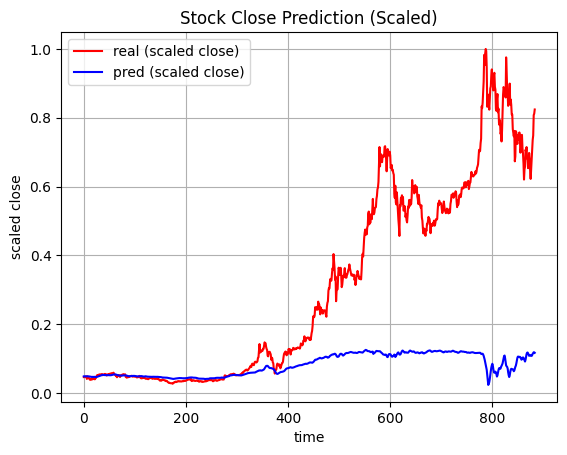

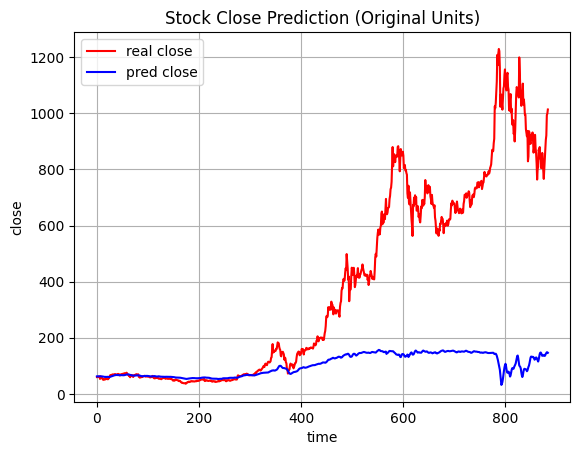

In [36]:
plt.figure()
plt.plot(test_y, color='red', label='real (scaled close)')
plt.plot(pred_y, color='blue', label='pred (scaled close)')
plt.title('Stock Close Prediction (Scaled)')
plt.xlabel('time')
plt.ylabel('scaled close')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(test_y_inv, color='red', label='real close')
plt.plot(pred_y_inv, color='blue', label='pred close')
plt.title('Stock Close Prediction (Original Units)')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [39]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(stock_AJ[['Open','High','Low','Volume','Close']])

In [40]:
feat_dim = 5  # (Open, High, Low, Volume, Close)
close_idx = 4 # 마지막 열

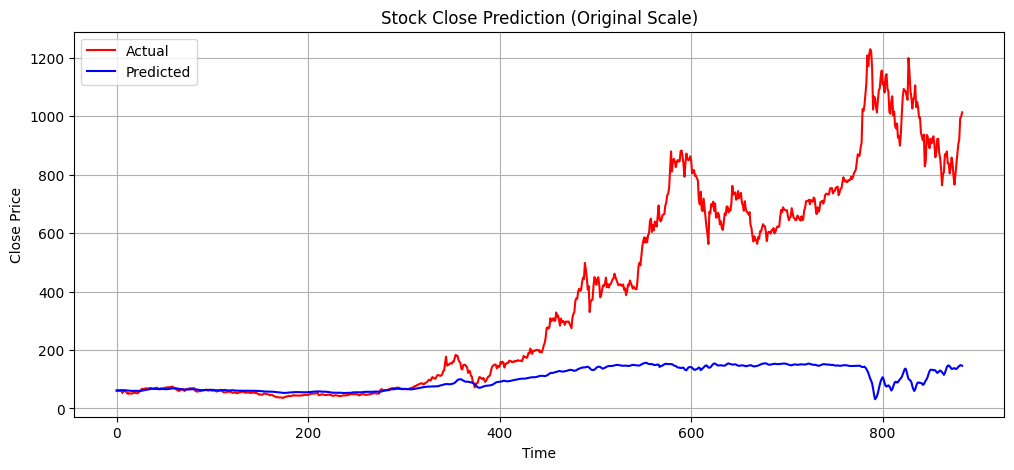

In [41]:
# pred_y 역변환
z = np.zeros((len(pred_y), feat_dim))
z[:, close_idx] = pred_y[:, 0]
pred_y_inv = scaler.inverse_transform(z)[:, close_idx]

# test_y 역변환
z = np.zeros((len(test_y), feat_dim))
z[:, close_idx] = test_y[:, 0]
y_test_inv = scaler.inverse_transform(z)[:, close_idx]

# 4) 그래프 그리기
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual', color='red')
plt.plot(pred_y_inv, label='Predicted', color='blue')
plt.title('Stock Close Prediction (Original Scale)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()